# COURSE: A deep understanding of deep learning
## SECTION: Autoencoders
### LECTURE: Autoencoder with tied weights
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [51]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/4x/pds2gxg17h57rrp30d736s1w0000gn/T/ipykernel_71967/1319117283.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# An aside on Linear vs. Parameter classes

In [52]:
# create an input and weights matrix
x  = torch.rand(10,50)
W1 = nn.Parameter(torch.randn(128,50))

# Let's see what W1 is
print(W1)
print('\n\n')

# # Its size and the size of its transpose
print(W1.shape)
print(W1.t().shape)
print('\n\n')

# # compute an output
y = x@W1.t()
print(y.shape)

Parameter containing:
tensor([[ 0.1140,  0.5544,  0.2608,  ..., -0.4209,  0.7152,  1.1991],
        [-2.0315,  1.5729,  0.4916,  ...,  1.3774, -0.0189, -1.2921],
        [ 0.9212, -0.5455,  3.2240,  ..., -1.1739,  1.2038,  0.0247],
        ...,
        [ 0.0112,  2.4892, -0.9394,  ...,  1.2686, -0.3553,  2.1143],
        [ 1.1096, -0.6997,  0.5363,  ...,  1.2845, -1.3042,  0.4317],
        [-0.8911, -1.2651, -0.1157,  ...,  0.9715,  0.8754,  0.2151]],
       requires_grad=True)



torch.Size([128, 50])
torch.Size([50, 128])



torch.Size([10, 128])


In [53]:
# Now try again with the Linear method
W2 = nn.Linear(128,50)

# Let's see what W2 is
print(W2)
print('\n\n')

# # Its size and the size of its transpose
print(W2.weight.shape)
print(W2.weight.t().shape)
print('\n\n')

# # compute an output
y = x @ (W2.weight)
print(y.shape)

Linear(in_features=128, out_features=50, bias=True)



torch.Size([50, 128])
torch.Size([128, 50])



torch.Size([10, 128])


In [54]:
# confusion from the previous cells
print(W1.shape)
print(W2.weight.shape)

# confusion solved ;)
# (size of W -> [outputs,inputs], but nn.Linear expects [inputs,outputs])

torch.Size([128, 50])
torch.Size([50, 128])


In [55]:
# see all attributes of the class Linear
dir(nn.Linear)

# and the docstring for Linear.forward
??nn.Linear.forward()
??nn.Linear.__init__() # note the inputs vs. how weight is created

Object `nn.Linear.forward()` not found.
Object `nn.Linear.__init__() # note the inputs vs. how weight is created` not found.


# Import and process the data

In [56]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

In [57]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Parameter(torch.randn(128,784))
      ### encoder layer
      self.enc = nn.Parameter(torch.randn(50,128))

    # forward pass
    def forward(self,x):
      x = x.t()  #784*5
      x = F.relu( self.input@x ) #128*5
      x = F.relu( self.enc@x ) #50*5
      # same for the decoding layer but reversed
      x = F.relu( self.enc.t()@x ) #128*5
      x = F.relu( self.input.t()@x )#784*5
      x = x.t()#5*784
      # "normal" final stage
      y = torch.sigmoid( x )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [58]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


# Create a function that trains the model

In [59]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=dataT.shape[0])
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.2799


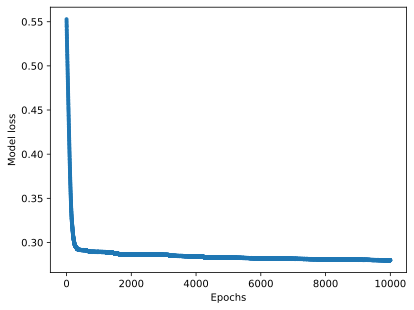

In [60]:
# train the model
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

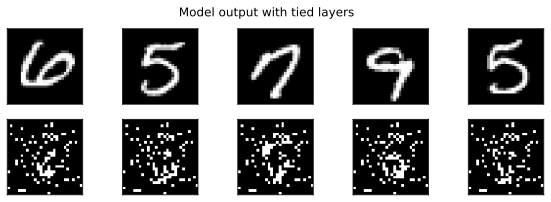

In [61]:
# Visualization of inputs and outputs
X = dataT[:5,:]
yHat = net(X)


# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Model output with tied layers')
plt.show()

# Add noise to see a use case of an autoencoder

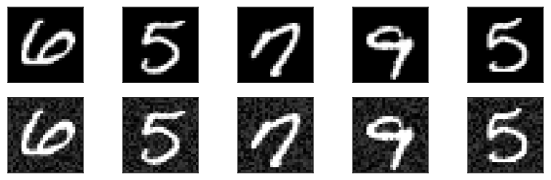

In [62]:
# grab a small set of images
X = dataT[:10,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.show()

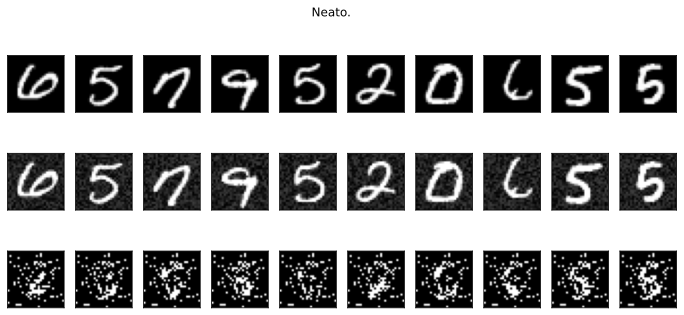

In [63]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.suptitle('Neato.')
plt.show()

# Additional explorations

In [64]:
# 1) The network we built here is not a truly mirrored network: We tied the encoder/decoder layers, but left the input
#    and output layers separate. That's not wrong or bad or anything; it's just a choice. Modify the code to create
#    a truly mirrored network, where all decoding layers are tied to their corresponding encoding layers.
# 
# 2) You don't need to use nn.Parameter; you can still accomplish what we did by using nn.Linear and extracting the
#    weights matrices. Rewrite the code to use nn.Linear instead of nn.Parameter.
# 